**Installing torch and other dependencies**

In [ ]:
#install Pytorch version 1.7.0
# you must have Python  3.7 to use torch 1.7.0 and Pytorch Geometric
!pip uninstall torch -y
!pip uninstall torchvision -y
!pip install torch==1.7.0

In [ ]:
# You must restart the runtime in order to use newly installed versions.
# Check pytorch version 
# Must be 1.7.0
# Python 3.7.13
!python -c "import torch; print(torch.__version__)"
!python --version

In [ ]:
# If something breaks in the notebook it is probably related to a mismatch between the Python version, CUDA or torch
import torch
pytorch_version = f"torch-{torch.__version__}+cu{torch.version.cuda.replace('.', '')}.html"
!pip install --no-index torch-scatter -f https://pytorch-geometric.com/whl/$pytorch_version
!pip install --no-index torch-sparse -f https://pytorch-geometric.com/whl/$pytorch_version
!pip install --no-index torch-cluster -f https://pytorch-geometric.com/whl/$pytorch_version
!pip install --no-index torch-spline-conv -f https://pytorch-geometric.com/whl/$pytorch_version
!pip install torch-geometric

**Necessary Imports**

In [1]:
from torch_geometric.datasets import MNISTSuperpixels
from torch.utils.data import DataLoader
from torch.nn import Linear
from torch_geometric.data import DataLoader
import torch.nn.functional as F 
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
import torch
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd 
import warnings
warnings.filterwarnings("ignore")

**Downloading Dataset**

In [2]:
# Load the MNISTSuperpixel dataset
# change "." to save it in your custom directory
data = MNISTSuperpixels(root=".")

**Data Visualization**

Is undirected: True


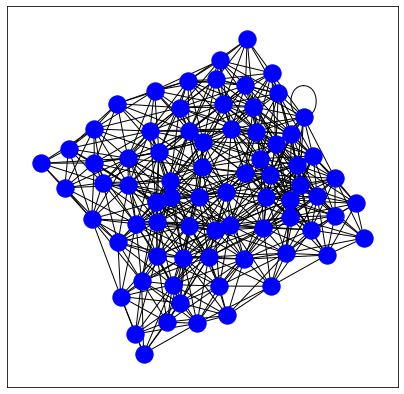

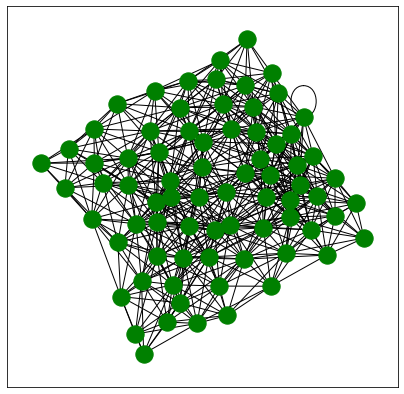

In [3]:
def visualize(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])

    if torch.is_tensor(h):
        h = h.detach().cpu().numpy()
        plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
        if epoch is not None and loss is not None:
            plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    else:
        nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                         node_color=color, cmap="Set2")
    plt.show()
dataset=data[82]
print(f'Is undirected: {dataset.is_undirected()}')
from torch_geometric.utils import to_networkx
G = to_networkx(dataset, to_undirected=True)
 
visualize(G, "blue") 
visualize(G, "green")

**Creating Graph CNN Model**

In [4]:
class GCN(torch.nn.Module):
    def __init__(self):
        # Init parent
        super(GCN, self).__init__()
        torch.manual_seed(42)
        # GCN layers
        embedding_size = 72
        self.initial_conv = GCNConv(data.num_features, embedding_size)
        self.conv1 = GCNConv(embedding_size, embedding_size)
        self.conv2 = GCNConv(embedding_size, embedding_size)
        self.conv3 = GCNConv(embedding_size, embedding_size)
        self.conv4 = GCNConv(embedding_size, embedding_size)
        self.conv5 = GCNConv(embedding_size, embedding_size)
        # Output layer
        self.out = Linear(embedding_size*2, data.num_classes)
    def forward(self, x, edge_index, batch_index):
        # First Conv layer
        hidden = self.initial_conv(x, edge_index)
        hidden = F.relu(hidden)
        # Other Conv layers
        hidden = self.conv1(hidden, edge_index)
        hidden = F.relu(hidden)
        hidden = self.conv2(hidden, edge_index)
        hidden = F.relu(hidden)
        hidden = self.conv3(hidden, edge_index)
        hidden = F.relu(hidden)
        hidden = self.conv4(hidden, edge_index)
        hidden = F.relu(hidden)
        hidden = self.conv5(hidden, edge_index)
        hidden = F.relu(hidden)
        # Global Pooling (stack different aggregations)
        hidden = torch.cat([gmp(hidden, batch_index), 
                            gap(hidden, batch_index)], dim=1)
        # Apply a final (linear) classifier.
        out = self.out(hidden)
        return out, hidden
model = GCN()
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

GCN(
  (initial_conv): GCNConv(1, 72)
  (conv1): GCNConv(72, 72)
  (conv2): GCNConv(72, 72)
  (conv3): GCNConv(72, 72)
  (conv4): GCNConv(72, 72)
  (conv5): GCNConv(72, 72)
  (out): Linear(in_features=144, out_features=10, bias=True)
)
Number of parameters:  27874


**Model Training**

In [7]:
# Cross EntrophyLoss
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)  
# Use GPU for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
# Wrap data in a data loader
data_size = len(data)
NUM_GRAPHS_PER_BATCH = 40
loader = DataLoader(data[:int(data_size * 0.6)], 
                    batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
test_loader = DataLoader(data[int(data_size * 0.6):], 
                         batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)

def train(data):
    # Enumerate over the data
    for batch in loader:
      # Use GPU
      batch.to(device)  
      # Reset gradients
      optimizer.zero_grad() 
      # Passing the node features and the connection info
      
      pred, embedding = model(batch.x.float(), batch.edge_index, batch.batch) 
      # Calculating the loss and gradients
      loss = torch.sqrt(loss_fn(pred, batch.y))       
      loss.backward()  
      # Update using the gradients
      optimizer.step()   
    return loss, embedding
print("Training started...")
losses = []
for epoch in range(2):
    loss, h = train(data)
    losses.append(loss)
    if epoch % 10 == 0:
      print(f"Epoch {epoch} | Train Loss {loss}")

Training started...
Epoch 0 | Train Loss 1.3904258012771606


**Getting Prediction**

In [8]:
test_batch = next(iter(test_loader))
with torch.no_grad():
    test_batch.to(device)
    pred, embed = model(test_batch.x.float(), test_batch.edge_index, test_batch.batch) 
    pred=torch.argmax(pred,dim=1)
print("Ground Truth: ",test_batch.y[0])#Actual REsult
print("Prediction: ",pred[0])#Predicted Result

Ground Truth:  tensor(8)
Prediction:  tensor(9)
